# Probabilistic Forecasting: Conformal Calibration

Conformal prediction is a framework for constructing prediction intervals that are guaranteed to contain the true value with a specified probability (coverage probability). In addition to generating prediction intervals from point forecasts, conformal methods can also calibrate intervals produced by other techniques, such as quantile regression or bootstrapped residuals. In such cases, the conformal method adjusts the intervals—either expanding or shrinking them—to ensure they achieve the desired coverage.

<p style="text-align: center">
    <img src="../img/conformal-interval-calibration.png" style="width: 450px">
    <br>
    <font size="2.5"> 
        <i>
        Conformal calibration of prediction intervals. Source: 
            <a href="https://leanpub.com/conformal-prediction" target="_blank"> 
                Introduction To Conformal Prediction With Python: A Short Guide For Quantifying Uncertainty Of Machine Learning Models 
            </a> 
        by Christoph Molnar
        </i>
    </font>
</p>

Skforecast provides this functionality through the [`ConformalIntervalCalibrator`](../api/preprocessing.html#skforecast.preprocessing.preprocessing.ConformalIntervalCalibrator) transformer that can be used for single series forecasting models as well as global forecasting models.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>

</div>

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme, plot_prediction_intervals

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.preprocessing import ConformalIntervalCalibrator
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster, backtesting_forecaster_multiseries
from skforecast.metrics import calculate_coverage

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

## Calibrate intervals using conformal methods

To understand how calibration works, a interval with a coverage of 67% is simulated and then calibrated to a coverage of 80%.

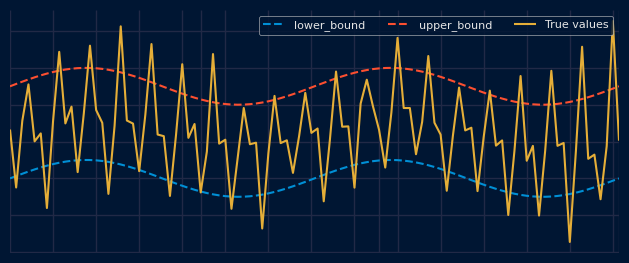

Coverage: 0.67


In [2]:
# Simulation of interval with coverage of 67%
# ==============================================================================
rng = np.random.default_rng(42)
interval = pd.DataFrame({
        'lower_bound': np.sin(np.linspace(0, 4 * np.pi, 100)),
        'upper_bound': np.sin(np.linspace(0, 4 * np.pi, 100)) + 5
    },
    index=pd.date_range(start='2024-01-01', periods=100, freq='D')
)
y_true = (interval['lower_bound'] + interval['upper_bound']) / 2 + rng.normal(0, 0.5, 100)
y_true.name = "series_1"
y_true.iloc[1::5] = interval.iloc[1::5, 0] - rng.normal(1, 1, 20)
y_true.iloc[3::5] = interval.iloc[1::5, 1] + rng.normal(1, 1, 20)

set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
interval.plot(ax=ax, linestyle="--")
y_true.plot(ax=ax, label='True values')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc="upper right", fontsize=8, ncol=3)
plt.show()

coverage = calculate_coverage(
               y_true      = y_true,
               lower_bound = interval["lower_bound"],
               upper_bound = interval["upper_bound"]
           )
print(f'Coverage: {coverage:.2f}')

The interval has a coverage of 67%, which means that the true values are within the interval 67% of the time. Next, the `ConformalIntervalCalibrator` transformer is used to calibrate the prediction interval to ensure that it has a coverage of 80%.

In [3]:
# Create and fit ConformalIntervalCalibrator
# ==============================================================================
calibrator = ConformalIntervalCalibrator(nominal_coverage=0.8)
calibrator.fit(y_true=y_true, y_pred_interval=interval)
calibrator

=========================== 
ConformalIntervalCalibrator 
=========================== 
Nominal coverage: 0.8 
Coverage in fit data: {'series_1': 0.67} 
Symmetric interval: True 
Symmetric correction factor: {'series_1': 0.9488126715432241} 
Asymmetric correction factor lower: {'series_1': 0.7640361794875151} 
Asymmetric correction factor upper: {'series_1': 1.0384612609432264} 
Fitted series: ['series_1']

The correction factor of 0.948 means that the interval needs to be expanded by 0.948 units in each direction to achieve the desired coverage of 80%.

Coverage: 0.80


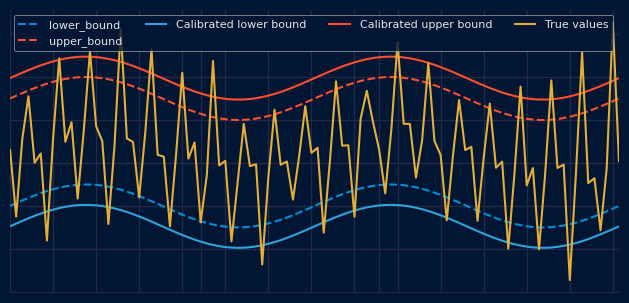

In [4]:
# Calibrate interval
# ==============================================================================
interval_calibrated = calibrator.transform(interval)

fig, ax = plt.subplots(figsize=(7, 3.5))
interval.plot(ax=ax, linestyle="--")
interval_calibrated["lower_bound"].plot(ax=ax, color="#30a2da", label="Calibrated lower bound")
interval_calibrated["upper_bound"].plot(ax=ax, color="#fc4f30", label="Calibrated upper bound")
y_true.plot(ax=ax, label="True values")
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc="upper right", fontsize=8, ncol=4)

coverage = calculate_coverage(
    y_true=y_true,
    lower_bound=interval_calibrated["lower_bound"],
    upper_bound=interval_calibrated["upper_bound"],
)
print(f"Coverage: {coverage:.2f}")

After calibration, the interval is widened to ensure that the true values are within the interval 80% of the time.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>
    For more details on conformal calibration method, see the faq section <a href="../faq/probabilistic-forecasting-calibrate-intervals.html" target="_blank">Calibration of probabilistic forecasting intervals</a>.
</p>

</div>

## Calibration of single series models

A `ForecasterRecursive` model is used to forecast prediction intervals with the [bootstrapped residuals method](../user_guides/probabilistic-forecasting-bootstrapped-residuals.html). A `ConformalIntervalCalibrator` transformer is then used to calibrate the prediction intervals to ensure they have the desired coverage probability.

In [5]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing', raw=False)
data = data[['users', 'temp', 'hum', 'windspeed', 'holiday']]
data = data.loc['2011-04-01 00:00:00':'2012-10-20 23:00:00', :].copy()
data.head(3)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 11)


,users,temp,hum,windspeed,holiday
date_time,,,,,
2011-04-01 00:00:00,6.0,10.66,100.0,11.0014,0.0
2011-04-01 01:00:00,4.0,10.66,100.0,11.0014,0.0
2011-04-01 02:00:00,7.0,10.66,93.0,12.9980,0.0


In [6]:
# Split data into: train-calibration-test
# ==============================================================================
end_train = '2012-06-30 23:59:00'
end_calibration = '2012-09-20 23:59:00'
data_train = data.loc[: end_train, :]
data_cal   = data.loc[end_train:end_calibration, :]
data_test  = data.loc[end_calibration:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates calibration: {data_cal.index.min()} --- {data_cal.index.max()}  (n={len(data_cal)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-04-01 00:00:00 --- 2012-06-30 23:00:00  (n=10968)
Dates calibration: 2012-07-01 00:00:00 --- 2012-09-20 23:00:00  (n=1968)
Dates test       : 2012-09-21 00:00:00 --- 2012-10-20 23:00:00  (n=720)


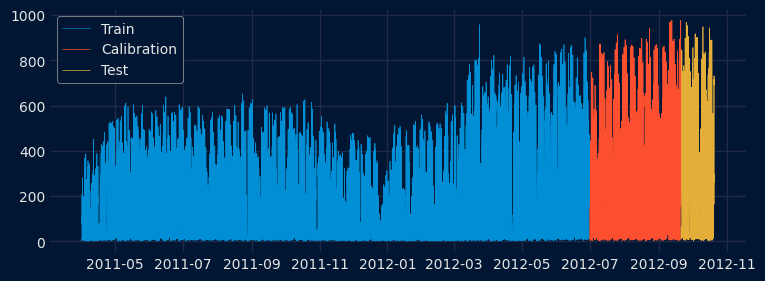

In [7]:
# Plot partitions
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['users'], label='Train')
ax.plot(data_cal['users'], label='Calibration')
ax.plot(data_test['users'], label='Test')
ax.legend();

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

<p>In this example, the data is divided into three partitions:</p>
<ul>
    <li><b>Training:</b> Used to train the model.</li>
    <li><b>Calibration:</b> Used to determine the correction factor needed to calibrate the prediction intervals.</li>
    <li><b>Test:</b> Used to evaluate the model’s predictions.</li>
</ul>
<p>If hyperparameter optimization or feature selection is required, a fourth partition should be used for validation.</p>

</div>

Prediction intervals are calculated for the test set using the bootstrapped residuals method with in-sample residuals. A backtesting is performed to simulate a realistic scenario where the model is trained with historical data and used to forecast future data in different time periods (each 24 `steps`).

In [8]:
# Create forecaster
# ==============================================================================
params = {
    "max_depth": 4,
    "n_estimators": 50,
    "verbose": -1,
    "random_state": 15926
}
lags = [1, 2, 3, 23, 24, 25, 167, 168, 169]

forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(**params),
                 lags      = lags,
             )

In [9]:
# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_calibration]),
         refit              = False
     )

metric, predictions_test = backtesting_forecaster(
                               forecaster              = forecaster,
                               y                       = data['users'],
                               cv                      = cv,
                               metric                  = 'mean_absolute_error',
                               interval                = [10, 90],  # 80% prediction interval
                               interval_method         = 'bootstrapping',
                               n_boot                  = 150,
                               use_in_sample_residuals = True,  # Use in-sample residuals
                               use_binned_residuals    = False
                           )
predictions_test.head(5)

  0%|          | 0/30 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-09-21 00:00:00,101.022472,52.198336,141.019309
2012-09-21 01:00:00,62.635418,11.930605,118.710325
2012-09-21 02:00:00,31.062836,-5.705437,117.264033
2012-09-21 03:00:00,15.166505,-24.902332,106.931933
2012-09-21 04:00:00,14.567935,-23.636627,109.814730


Coverage: 63.33 %
Area: 90704.43


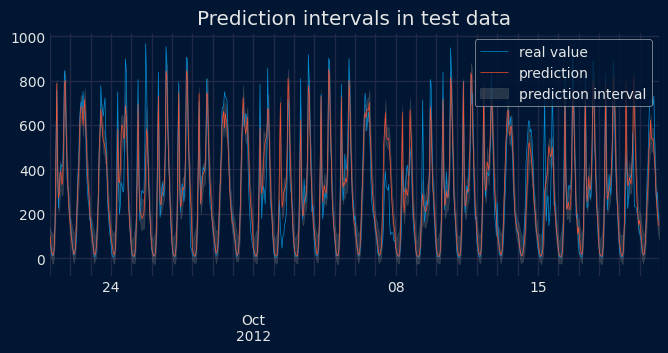

In [10]:
# Predicted interval coverage and area (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_calibration:, 'users'],
               lower_bound = predictions_test["lower_bound"], 
               upper_bound = predictions_test["upper_bound"]
           )
area = (predictions_test["upper_bound"] - predictions_test["lower_bound"]).sum()
print(f"Coverage: {round(100 * coverage, 2)} %")
print(f"Area: {round(area, 2)}")

# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions         = predictions_test,
    y_true              = data_test,
    target_variable     = "users",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

As expected, since in-sample residuals are used, the prediction intervals are too narrow and do not achieve the desired coverage probability of 80%.

Conformal methods allow to calibrate prediction intervals generated by other techniques, such as quantile regression or bootstrapped residuals. The `ConformalIntervalCalibrator` transformer uses the [Split Conformal Prediction (SCP)](https://mapie.readthedocs.io/en/stable/theoretical_description_regression.html#the-split-method) method to learn the correction factor needed to expand or shrink the prediction intervals to ensure they are valid with respect to a given coverage probability. This method consists of the following steps:

1. Prediction intervals are estimated for the **calibration set** (bootstrapping). 
   
2. Using the predicted intervals and the actual values of the calibration set, the `ConformalIntervalCalibrator` transformer learns the **correction factor** needed to calibrate this intervals. 
   
3. Prediction intervals for the **test set** are adjusted using the correction factor learned from the calibration set.

In [ ]:
# Predict intervals for the calibration set
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_train]),
         refit              = False
     )

_, predictions_cal = backtesting_forecaster(
                         forecaster              = forecaster,
                         y                       = data.loc[:end_calibration, 'users'],
                         cv                      = cv,
                         metric                  = 'mean_absolute_error',
                         interval                = [10, 90],  # 80% prediction interval
                         interval_method         = 'bootstrapping',
                         n_boot                  = 150,
                         use_in_sample_residuals = True,  # Use in-sample residuals
                         use_binned_residuals    = False
                     )

predictions_cal.head(5)

  0%|          | 0/82 [00:00<?, ?it/s]

In [ ]:
# Fit a ConformalIntervalCalibrator transformer using the calibration set
# ==============================================================================
calibrator = ConformalIntervalCalibrator(nominal_coverage=0.8)
calibrator.fit(
    y_true          = data.loc[predictions_cal.index, 'users'],
    y_pred_interval = predictions_cal[['lower_bound', 'upper_bound']]
)
calibrator

=========================== 
ConformalIntervalCalibrator 
=========================== 
Nominal coverage: 0.8 
Coverage in fit data: {'users': 0.671239837398374} 
Symmetric interval: True 
Symmetric correction factor: {'users': 38.44337182009968} 
Asymmetric correction factor lower: {'users': 34.81994291446681} 
Asymmetric correction factor upper: {'users': 41.052400017672596} 
Fitted series: ['users']

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff9100;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>

It is highly recommended to review the coverage observed in the calibration set, stored in the <code>fit_coverage_</code> attribute of <code>ConformalIntervalCalibrator</code> object. The assumption is that similar coverage will be observed in the test set, allowing the correction factor to be applied effectively.

However, if the coverage differs between the calibration and test sets, the correction factor may not be appropriate. For instance, suppose the nominal coverage is 80%, but the calibration set achieves only 70%. In this case, the calibrator will learn a correction factor that expands the intervals to reach the desired 80% coverage. However, if the test set already has 90% coverage, applying the same correction factor would further widen the intervals instead of shrinking them, resulting in incorrect calibration.

By reviewing the calibration coverage beforehand, you can verify whether the correction factor is valid for the test set, preventing potential miscalibrations.
</p>

</div>

The correction factor is positive, indicating that the `ConformalIntervalCalibrator` is learning that the prediction intervals are too narrow and need to be widened to achieve the desired probability of coverage. 

The already calculated prediction intervals of the test set are now calibrated.

In [ ]:
# Calibrate prediction intervals of the test set
# ==============================================================================
predictions_test_calibrated = calibrator.transform(
    predictions_test[["lower_bound", "upper_bound"]]
)
predictions_test_calibrated.head(3)

,level,lower_bound,upper_bound
2012-09-21 00:00:00,users,19.115695,178.992019
2012-09-21 01:00:00,users,-28.519625,158.498032
2012-09-21 02:00:00,users,-42.615271,144.280974


Coverage: 79.72 %
Area: 148715.75


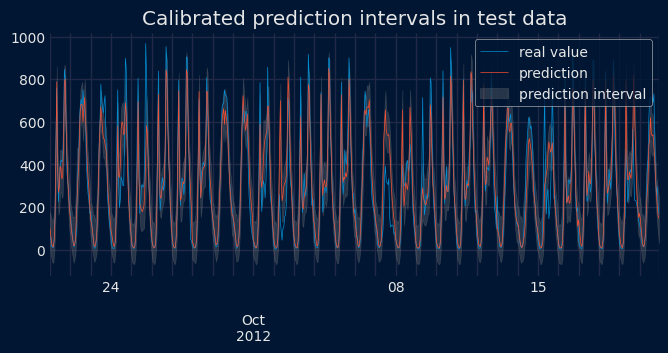

In [ ]:
# Plot intervals
# ==============================================================================
predictions_test_calibrated['pred'] = predictions_test['pred']
plot_prediction_intervals(
    predictions         = predictions_test_calibrated,
    y_true              = data_test,
    target_variable     = "users",
    title               = "Calibrated prediction intervals in test data",
    kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
)

# Predicted interval coverage and area (on test data)
# ==============================================================================
coverage = calculate_coverage(
               y_true      = data.loc[end_calibration:, 'users'],
               lower_bound = predictions_test_calibrated["lower_bound"], 
               upper_bound = predictions_test_calibrated["upper_bound"]
           )
area = (predictions_test_calibrated["upper_bound"] - predictions_test_calibrated["lower_bound"]).sum()
print(f"Coverage: {round(100 * coverage, 2)} %")
print(f"Area: {round(area, 2)}")

After calibration, the prediction intervals achieve an empirical coverage very close to the nominal coverage of 80%.

## Calibration for global models

Same process of calibration can be applied to [global models](../user_guides/independent-multi-time-series-forecasting.html), `ForecasterRecursiveMultiSeries`. In this case, the `ConformalIntervalCalibrator` transformer is fitted with the calibration intervals of multiple series.

In [ ]:
# Data
# ==============================================================================
data = fetch_dataset(name="ett_m2_extended")
data = data.resample(rule="1h", closed="left", label="right").mean()
data = data.loc[:'2016-10-31 23:59:00', :].copy()
data.head(2)

ett_m2_extended
---------------
Data from an electricity transformer station was collected between July 2016 and
July 2018 (2 years x 365 days x 24 hours x 4 intervals per hour = 70,080 data
points). Each data point consists of 8 features, including the date of the
point, the predictive value "Oil Temperature (OT)", and 6 different types of
external power load features: High UseFul Load (HUFL), High UseLess Load (HULL),
Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),
Low UseLess Load(LULL). Additional variables are created based on calendar
information (year, month, week, day of the week, and hour). These variables have
been encoded using the cyclical encoding technique (sin and cos transformations)
to preserve the cyclical nature of the data.
Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &
Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for
Long Sequence Time-Series Forecasting.
[10.48550/arXiv.2012.

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date,,,,,,,,,,,,,,,,
2016-07-01 01:00:00,38.784501,10.88975,34.753500,8.551,4.12575,1.2605,37.83825,2016.0,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.000000,1.000000
2016-07-01 02:00:00,36.041249,9.44475,32.696001,7.137,3.59025,0.6290,36.84925,2016.0,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.258819,0.965926


In [ ]:
# Split data into: train-calibration-test
# ==============================================================================
end_train = '2016-08-31 23:59:00'
end_calibration = '2016-09-30 23:59:00'
data_train = data.loc[: end_train, :]
data_cal   = data.loc[end_train:end_calibration, :]
data_test  = data.loc[end_calibration:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates calibration: {data_cal.index.min()} --- {data_cal.index.max()}  (n={len(data_cal)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 01:00:00 --- 2016-08-31 23:00:00  (n=1487)
Dates calibration: 2016-09-01 00:00:00 --- 2016-09-30 23:00:00  (n=720)
Dates test       : 2016-10-01 00:00:00 --- 2016-10-31 23:00:00  (n=744)


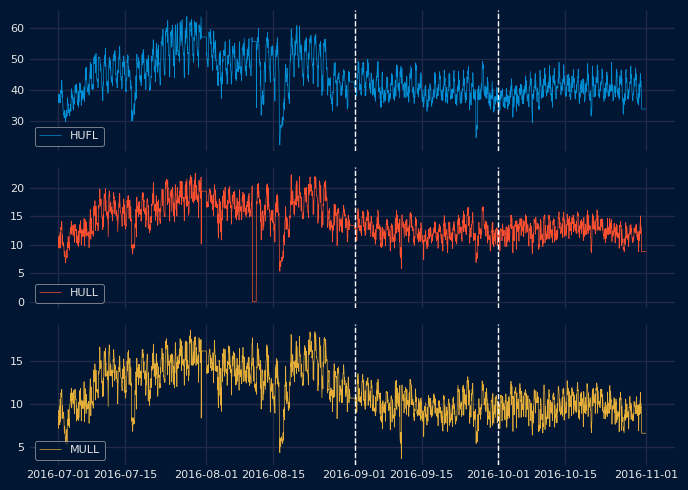

In [ ]:
# Plot partitions
# ==============================================================================
series = ['HUFL', 'HULL', 'MULL']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
for i, col in enumerate(series):
    axs[i].plot(data[col], label=col, color=colors[i])
    axs[i].legend(loc='lower left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train
    axs[i].axvline(pd.to_datetime(end_calibration), color='white', linestyle='--', linewidth=1)  # End validation

plt.tight_layout()
plt.show()

In [ ]:
# Create forecaster
# ==============================================================================
exog_features = [
    'year', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'day_of_week_sin',
    'day_of_week_cos', 'hour_sin', 'hour_cos'
]
lags = [1, 3, 11, 12, 13, 14, 15, 17, 23, 24, 25, 49, 73, 97, 145]

forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = Ridge(random_state=15926),
                 lags               = lags,
                 encoding           = 'ordinal',
                 transformer_series = StandardScaler(),
                 transformer_exog   = StandardScaler(),
                 differentiation    = 1,
                 binner_kwargs      = {'n_bins': 5}
             )

In [ ]:
# Backtesting on test data using in-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_calibration, :]),
         steps              = 24,
         differentiation    = 1,
     )

metric_test, predictions_test = backtesting_forecaster_multiseries(
                                    forecaster              = forecaster,
                                    series                  = data.loc[:, series],
                                    exog                    = data.loc[:, exog_features],
                                    cv                      = cv,
                                    metric                  = 'mean_absolute_error',
                                    interval                = [10, 90],
                                    interval_method         = "bootstrapping",
                                    n_boot                  = 150,
                                    use_in_sample_residuals = True,
                                    use_binned_residuals    = True
                                )

  0%|          | 0/31 [00:00<?, ?it/s]

In [ ]:
# Coverage and area for each level
# ==============================================================================
for level in predictions_test["level"].unique():
    predictions_level = (
        predictions_test[predictions_test["level"] == level]
        .drop(columns="level")
        .copy()
    )
    coverage = calculate_coverage(
        y_true=data_test[level],
        lower_bound=predictions_level["lower_bound"],
        upper_bound=predictions_level["upper_bound"],
    )
    area = (predictions_level["upper_bound"] - predictions_level["lower_bound"]).sum()
    print(f"{level} - Coverage: {round(100 * coverage, 2)} % - Area: {round(area, 2)}")

HUFL - Coverage: 96.24 % - Area: 11094.31
HULL - Coverage: 97.58 % - Area: 6712.73
MULL - Coverage: 96.77 % - Area: 5473.82


In this example, eventhough the intervals are calculated using in-sample residuals, the coverage is higher than the nominal coverage of 80%. Next, they are calibrated using the `ConformalIntervalCalibrator` transformer.

In [ ]:
# Backtesting on calibration set
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_train, :]),
         steps              = 24,
         differentiation    = 1,
     )

metric_cal, predictions_cal = backtesting_forecaster_multiseries(
                                  forecaster              = forecaster,
                                  series                  = data.loc[:end_calibration, series],
                                  exog                    = data.loc[:end_calibration, exog_features],
                                  cv                      = cv,
                                  metric                  = 'mean_absolute_error',
                                  interval                = [10, 90],
                                  interval_method         = "bootstrapping",
                                  n_boot                  = 150,
                                  use_in_sample_residuals = True,
                                  use_binned_residuals    = True
                              )

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# Create and fit ConformalIntervalCalibrator
# ==============================================================================
calibrator = ConformalIntervalCalibrator(nominal_coverage=0.8)
calibrator.fit(
    y_true = data_cal[series],
    y_pred_interval = predictions_cal
)
calibrator

=========================== 
ConformalIntervalCalibrator 
=========================== 
Nominal coverage: 0.8 
Coverage in fit data: {'HUFL': 0.9694444444444444, 'HULL': 0.9833333333333333, 'MULL': 0.9680555555555556} 
Symmetric interval: True 
Symmetric correction factor: {'HUFL': -2.787851720985961, 'HULL': -1.9653641691179158, 'MULL': -1.4805341783220336} 
Asymmetric correction factor lower: {'HUFL': -2.090525169340753, 'HULL': -1.383063856197552, 'MULL': -0.9309778691563908} 
Asymmetric correction factor upper: {'HUFL': -3.5702368376900275, 'HULL': -2.578652435761735, 'MULL': -1.9755760820759365} 
Fitted series: ['HUFL', 'HULL', 'MULL']

The correction factor of all levels is negative, which means that the prediction intervals are too wide and need to be narrowed to achieve the desired coverage probability.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff9100;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>

It is highly recommended to review the coverage observed in the calibration set, stored in the <code>fit_coverage_</code> attribute of <code>ConformalIntervalCalibrator</code> object. The assumption is that similar coverage will be observed in the test set, allowing the correction factor to be applied effectively.

However, if the coverage differs between the calibration and test sets, the correction factor may not be appropriate. For instance, suppose the nominal coverage is 80%, but the calibration set achieves only 70%. In this case, the calibrator will learn a correction factor that expands the intervals to reach the desired 80% coverage. However, if the test set already has 90% coverage, applying the same correction factor would further widen the intervals instead of shrinking them, resulting in incorrect calibration.

By reviewing the calibration coverage beforehand, you can verify whether the correction factor is valid for the test set, preventing potential miscalibrations.
</p>

</div>

In [ ]:
# Calibrate prediction intervals of the test set
# ==============================================================================
predictions_test_calibrated = calibrator.transform(predictions_test)
predictions_test_calibrated.head(3)

,level,lower_bound,upper_bound
2016-10-01 00:00:00,HUFL,35.454979,36.846566
2016-10-01 01:00:00,HUFL,34.322673,34.918745
2016-10-01 02:00:00,HUFL,32.518754,33.994147


HUFL - Coverage: 79.84 % - Area: 7044.41
HULL - Coverage: 77.69 % - Area: 3855.71
MULL - Coverage: 77.42 % - Area: 3341.42


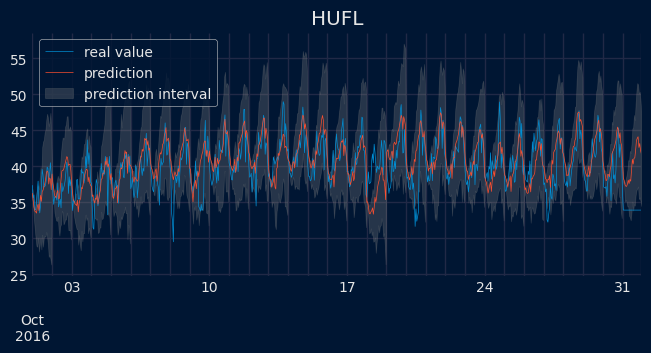

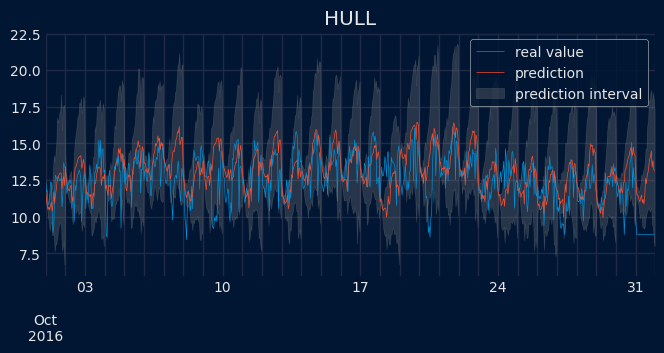

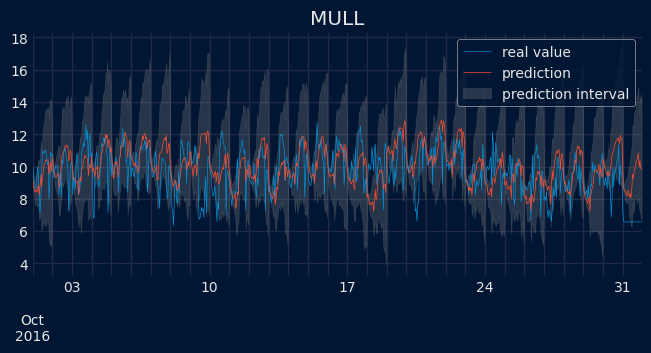

In [ ]:
# Prediction intervals on test data after calibration
# ==============================================================================
for level in predictions_test_calibrated["level"].unique():
    predictions_level = (
        predictions_test_calibrated[predictions_test_calibrated["level"] == level]
        .drop(columns="level")
        .copy()
    )
    predictions_level['pred'] = predictions_test.loc[predictions_test['level'] == level, 'pred']
        
    plot_prediction_intervals(
        predictions         = predictions_level,
        y_true              = data_test[[level]],
        target_variable     = level,
        title               = level,
        kwargs_fill_between = {'color': 'gray', 'alpha': 0.3, 'zorder': 1}
    )
    coverage = calculate_coverage(
                   y_true      = data_test[level],
                   lower_bound = predictions_level["lower_bound"],
                   upper_bound = predictions_level["upper_bound"],
               )
    area = (predictions_level["upper_bound"] - predictions_level["lower_bound"]).sum()
    print(f"{level} - Coverage: {round(100 * coverage, 2)} % - Area: {round(area, 2)}")